#  Section 1: Codes for LDPM

In [1]:
import cv2
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

#### Codes below are used to generate LDP file names containing information of cell concentration and light intensity.  
The format of file name here is 'C1_200.jpg'.  
where C1 stand for cell concentration and 200 stand for light intensity (x100 lux).

In [2]:
conc = []
filenames = []
light = [60,100,150,200,320,400]    

for i in range(1,24):
    conc.append("C"+str(i))
for i in conc:
    for j in light:        
        filenames.append(i + '_' + str(j)+'.jpg')  
        
print(filenames[0], len(filenames)) #expected output: C1_60.jpg  138 

C1_60.jpg 138


#### Codes below is to define a dictionary containing actual cell concentrations of C1-C24 (dry cell weight, dcw)

In [3]:
dcw = {'C1':'0.11973','C2':'0.21294','C3':'0.40872','C4':'0.45162','C5':'0.54405','C6':'0.62712','C7':'0.74256',
       'C8':'0.82056','C9':'0.90948','C10':'0.96915','C11':'1.10604','C12':'1.2246','C13':'1.3026','C14':'1.3923',
       'C15':'1.443','C16':'1.5444','C17':'1.7901','C18':'1.9188','C19':'2.0241','C20':'2.3556','C21':'2.535',
       'C22':'2.9601','C23':'3.6777'}  

dcw_norm = {'C1':-1.38513019,'C2':-1.28029953,'C3':-1.06011128,'C4': -1.01186285, 'C5':-0.90790944,'C6':-0.81448295,'C7':-0.68465083,'C8':-0.59692643,
       'C9':-0.49692061,'C10':-0.42981144,'C11':-0.27585511,'C12':-0.14251401,'C13':-0.05478961,'C14':0.04609345,'C15':0.10311432,
       'C16':0.21715604,'C17':0.49348791,'C18':0.63823318,'C19':0.75666112,'C20':1.12948984,'C21':1.33125597,
       'C22':1.80935397,'C23':2.61641848}  

light = {'60':107,'100':178,'150':267,'200':357,'320':570,'400':714}
light_norm = {'60':-1.20739588,'100':-0.87577071,'150':-0.46007155,'200':-0.03970161,'320':0.95517392,'400':1.62776582}

#### Codes below is to define some useful functions

In [4]:
def extract_data_from_imgs(imgs):  #extract GSVs from images
    Data = {}
    for img in imgs:
        gray_img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        Data[img] = gray_img
    return Data

def best_parameters(X,y,X_test,y_test):    #training and get best parameters for models at each pixel
    C = [1,10,100, 1e3,3e3]
    gamma = [0.003,0.01,0.03,0.1,0.3,1]
    best_C = 0
    best_gamma = 0
    max_rs = -100
    for c in C:
        for g in gamma:
            svr_rbf = SVR(kernel='rbf', C=c, gamma=g)
            svr_rbf.fit(np.array(X), y)
            yhat = svr_rbf.predict(np.array(X_test))
            rs = r2_score(yhat,y_test)
            if rs > max_rs and rs <1:
                max_rs =rs
                best_C = c
                best_gamma = g    
    return best_C,best_gamma, max_rs

def get_data_at_row_col(Data, row, col):   #extract GSVs at each pixels 
    label_row_col = []
    X_row_col_conc = []
    X_row_col_light = []
    X = []
    for key, val in Data.items():
        X_row_col_conc.append(float(dcw[key.split('_')[0]]))
        X_row_col_light.append(key.split('_')[1].split('.')[0])
        label_row_col.append(val[row][col])
    X.append(X_row_col_conc)
    X.append(X_row_col_light)
    X = np.array(X)
    X = X.T
    return X, label_row_col

def prediction(X, y, c, g, test_conc):    #prediction 
    svr_rbf = SVR(kernel='rbf', C=c, gamma=g)
    svr_rbf.fit(np.array(X) , y)
    yhat = svr_rbf.predict(np.array(test_conc))
    return yhat

def img_to_df(imgs):
    Data = []
    for img in imgs:
        gray_img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        Data.append(list(gray_img.reshape(-1)))
    df = pd.DataFrame(Data,index = imgs)
    return df

def get_data_at_row_col(df, row):   #extract GSVs at each pixels 
    label_row_train = []
    X_row_conc_train = []
    X_row_light_train = []
    X_train = []
    
    label_row_test = []
    X_row_conc_test = []
    X_row_light_test = []
    X_test = []
    
    df_train = df[df['is_train'] == True]
    df_test = df[df['is_train'] == False]
    
    for key in list(df_train.index):
        X_row_conc_train.append(float(dcw_norm[key.split('_')[0]]))
        X_row_light_train.append(float(light_norm[key.split('_')[1].split('.')[0]]))
        label_row_train.append(df_train[row][key])
    X_train.append(X_row_conc_train)
    X_train.append(X_row_light_train)
    X_train = np.array(X_train)
    X_train = X_train.T
    
    for key in list(df_test.index):
        X_row_conc_test.append(float(dcw_norm[key.split('_')[0]]))
        X_row_light_test.append(float(light_norm[key.split('_')[1].split('.')[0]]))
        label_row_test.append(df_test[row][key])
    X_test.append(X_row_conc_test)
    X_test.append(X_row_light_test)
    X_test = np.array(X_test)
    X_test = X_test.T
    
    return X_train, label_row_train, X_test, label_row_test

def training(df,pos):
    parameters = {}
    for i in pos:
        if i % 50 == 0:
            print('Training for pixel '+ str(i) + '  |   ' + str(i/len(pos)*100) + ' % completed')
        key = 'row_' + str(i)
        X_train,y_train, X_test, y_test = get_data_at_row_col(df, str(i))
        [best_C,best_gamma, max_rs] = best_parameters(X_train,y_train,X_test,y_test)
        parameters[key] = [best_C,best_gamma, max_rs]
    return parameters

def output_organize(parameters):
    pos = []
    c = []
    gamma = []
    rs = []
    for key, val in parameters.items():
        pos.append(key)
        c.append(val[0])
        gamma.append(val[1])
        rs.append(val[2])
    
    df = pd.DataFrame()
    df['pos'] = pos
    df['C'] = c
    df['Gamma'] = gamma
    df['R-squared'] = rs
    return df

def de_norm_GSV(GSVs):
    GSVs = np.array(GSVs) * 46.22 + 38.77
    return GSVs
def norm_features(features):
    features_norm = []
    for i in range(len(features)):
        temp = []
        temp.append((np.array(features[i][0]) *1.1247)-1.5198)
        temp.append((np.array(features[i][1]) - 365.5)/214.09713527586803)
        features_norm.append(temp)
    return np.array(features_norm)

def get_best_parameters(training_df,pos):
    parameters = training(training_df,pos)
    df = output_organize(parameters)
    return df

def extract_X_from_growth_curve_and_norm(growth_curve):
    df = pd.read_csv(growth_curve)
    features = ['DCW','Light']
    X = []
    for i in range(len(df)):
        temp = []
        temp.append(df['DCW'][i])
        temp.append(df['Light'][i])
        X.append(temp)
    X = norm_features(X)
    df[features] = X
    return df,X

def prediction(X, y, c, g, X_test):
    svr_rbf = SVR(kernel='rbf', C=c, gamma=g)
    svr_rbf.fit(np.array(X) , y)
    yhat = svr_rbf.predict(np.array(X_test))
    return yhat

def LDP_prediction(df_training,df_parameter,pos,X):
    all_pred_for_GRM = []
    all_y_test = []
    for i in pos:
        X_train,y_train, X_test, y_test = get_data_at_row_col(df_training, str(i))
        c = df_parameter['C'][i]
        g = df_parameter['Gamma'][i]
        yhat = prediction(X_train, y_train, c, g, np.array(X))
        all_pred_for_GRM.append(list(yhat))
        all_y_test.append(list(y_test))
    return all_pred_for_GRM, all_y_test

def LDP_organization(pred,df_growth):
    LDP = ['R0','R1','R2','R3','R4','R5','R6','R7','R8']
    for i in range(9):
        df_growth[LDP[i]] =  np.array(pred).T[:,i]
    return df_growth

def GRM_training_prediction(df_training,X_pred):
    LDP = ['R0','R1','R2','R3','R4','R5','R6','R7','R8']
    train = df_training[df_training['is_train'] == True]
    test = df_training[df_training['is_train'] == False]
    X_train = train[LDP]
    y_train = train['Growth rate']
    X_test = test[LDP]
    y_test = test['Growth rate']
    
    RF = RandomForestRegressor()
    RF.fit(X_train, y_train)
    yhat = RF.predict(X_test)
    rs = r2_score(y_test,yhat)
    
    if len(X_pred) > 0:
        y_pred = RF.predict(X_pred)
    else:
        y_pred = []
        
    return np.array(y_test),np.array(yhat),np.array(y_pred),rs

def dcw_normalization(dcw_):
    dcw_ = (np.array(dcw_) *1.1247)-1.5198
    return dcw_

def dcw_denormalization(dcw_norm_):
    dcw_ = (np.array(dcw_norm_)  + 1.5198)/1.1247
    return dcw_

def light_normalization(light_mol):
    light = (np.array(light_mol) - 365.5)/214.09713527586803
    return light

def simulation_update(X_new,gr,new_light,interval):
    updated_X_new = []

    for i in range(len(X_new)):
        feature_temp = []
        feature_temp.append(dcw_normalization(dcw_denormalization(X_new[i][0]) + gr[i]*interval))
        feature_temp.append(new_light)
        updated_X_new.append(feature_temp)
    return np.array(updated_X_new)

def run_simulation(initial_conc, light_program,interval):
    df1 = pd.read_csv('LDP_data_norm_train_test.csv')
    df1.set_index('index', inplace=True)
    df3 = pd.read_csv('Parameters_for_LDPM.csv')
    _,X = extract_X_from_growth_curve_and_norm('growth_fitted_to_curve_for_LDP_prediction.csv')
    df4 = pd.read_csv('Training_for_GRM.csv')
    
    record = []
    light_ = light_normalization(light_program)
    X_new = []
    
    for i in initial_conc:
        feature_temp = []
        feature_temp.append(dcw_normalization(i))
        feature_temp.append(light_[0])
        X_new.append(feature_temp)
    X_new = np.array(X_new)
    record.append(list(X_new))
    
    
    for i in range(1,len(light_)):
        pred_LDP,y_test = LDP_prediction(df1,df3,list(range(18,180,20)),X_new)
        
        _,__,gr,___ = GRM_training_prediction(df4,np.array(pred_LDP).T)
        X_new = simulation_update(X_new,gr,light_[i],interval)
        record.append(list(X_new))
        if i%10 ==0:
            print('Simulation in progress ...', i/len(light_)*100, ' % Finished')
    return record


# functions needed for double light predictions

def X_organization(df):
    X_LDP = []
    for i in range(len(df)):
        temp = []
        temp.append(df['DCW_norm'][i])
        temp.append(df['Light_norm'][i])
        X_LDP.append(temp)
    X_LDP =np.array(X_LDP)
    return X_LDP

def LDP_organization_dlight(pred,df_growth):
    LDP = ['R0','R1','R2','R3','R4']
    for i in range(5):
        #print(len(df_growth[LDP[i]]),len())
        df_growth[LDP[i]] =  np.array(pred).T[:,i]
    return df_growth

def GRM_training_prediction_dlight(df_training,X_pred):
    #print(df_training)
    LDP = ['R0','R1','R2','R3','R4']
    train = df_training[df_training['is_train'] == True]
    test = df_training[df_training['is_train'] == False]
    X_train = train[LDP]
    y_train = train['Growth rate']
    X_test = test[LDP]
    y_test = test['Growth rate']
    
    RF = RandomForestRegressor()
    RF.fit(X_train, y_train)
    yhat = RF.predict(X_test)
    rs = r2_score(y_test,yhat)
    
    if len(X_pred) > 0:
        y_pred = RF.predict(X_pred)
    else:
        y_pred = []
        
    return np.array(y_test),np.array(yhat),np.array(y_pred),rs

def run_simulation_dlight(initial_conc, light_program,interval):
    df1 = pd.read_csv('LDP_data_norm_train_test.csv')
    df1.set_index('index', inplace=True)
    df3 = pd.read_csv('Best_parameters_SVR_retrain_up-to_3000_best.csv')
    df6 = pd.read_csv('growth_double_light_fitted_to_curve_w_LDP.csv')
    X = X_organization(df6)
    
    record = []
    light_ = light_normalization(light_program)
    X_new = []
    
    for i in initial_conc:
        feature_temp = []
        feature_temp.append(dcw_normalization(i))
        feature_temp.append(light_[0])
        X_new.append(feature_temp)
    X_new = np.array(X_new)
    record.append(list(X_new))
    
    
    for i in range(1,len(light_)):
        pred_LDP,y_test = LDP_prediction(df1,df3,list(range(18,100,20)),X_new)

        _,__,gr,___ = GRM_training_prediction_dlight(df6,np.array(pred_LDP).T)

        X_new = simulation_update(X_new,gr,light_[i],interval)

        record.append(list(X_new))
        if i%10 ==0:
            print('Simulation in progress ...', i/len(light_)*100, ' % Finished')
    return record


#### Below section is to train models and get best parameters for each pixel.
It takes ~ 10 min to train  all pixels. 

In [5]:
# read training data 
df1 = pd.read_csv('LDP_data_norm_train_test.csv')
df1.set_index('index', inplace=True)

#Model training to get best parameters for SVR 
#Output: a dataframe contains parameters and r2 scores for SVR at each pixels
df2 = get_best_parameters(df1,list(range(720)))

#sotre the output df to a csv file 
df2.to_csv('Parameters_for_LDPM.csv')

#check the first 5 row of the csv file
df2.head()

Training for row 0  |   0.0 % completed
Training for row 50  |   6.944444444444445 % completed
Training for row 100  |   13.88888888888889 % completed
Training for row 150  |   20.833333333333336 % completed
Training for row 200  |   27.77777777777778 % completed
Training for row 250  |   34.72222222222222 % completed
Training for row 300  |   41.66666666666667 % completed
Training for row 350  |   48.61111111111111 % completed
Training for row 400  |   55.55555555555556 % completed
Training for row 450  |   62.5 % completed
Training for row 500  |   69.44444444444444 % completed
Training for row 550  |   76.38888888888889 % completed
Training for row 600  |   83.33333333333334 % completed
Training for row 650  |   90.27777777777779 % completed
Training for row 700  |   97.22222222222221 % completed


,pos,C,Gamma,R-squared
0,row_0,1000.0,1.0,0.970885
1,row_1,1000.0,1.0,0.984290
2,row_2,3000.0,1.0,0.990594
3,row_3,100.0,1.0,0.987779
4,row_4,1000.0,1.0,0.984534


#### Below section is to peform predictions
Codes provided is to validate the LDPM prediction and generate figure 1D. <br>



In [6]:
#Model validation with testing samples

#creat a list to store all predicted GSVs
all_pred_GSV = []

# creat a list to store all measured GSVs (actual GSVs in testing samples)
all_y_test = []

# Prediction and extracting y_test
for i in range(720):
    X_train,y_train, X_test, y_test = get_data_at_row_col(df1, str(i))
    c = df2['C'][i]
    g = df2['Gamma'][i]
    yhat = prediction(X_train, y_train, c, g, np.array(X_test))
    all_pred_GSV.append(list(yhat))
    all_y_test.append(list(y_test))

# de_normlize GSVs and store the values in a dataframe
df3 = pd.DataFrame()
df3['Measured GSV'] = de_norm_GSV(np.array(all_y_test).reshape(-1))
df3['Predicted GSV'] = de_norm_GSV(np.array(all_pred_GSV).reshape(-1))

# store the df into a csv file
df3.to_csv('Measured_and_Predicted_GSV.csv')

# show the head of the df
df3.head()


,Measured GSV,Predicted GSV
0,104.0,114.661894
1,184.0,178.864538
2,138.0,135.346379
3,82.0,78.279734
4,85.0,91.743404


0.9940861402619067


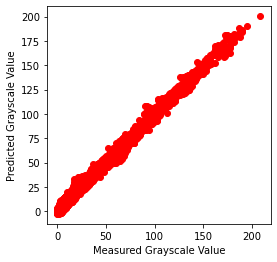

In [7]:
#plot the predicted results and calculate r2
figure =  plt.figure(figsize=(4,4))
plt.plot(df3['Measured GSV'],df3['Predicted GSV'],'ro')
r2 = r2_score(df3['Measured GSV'],df3['Predicted GSV'])
plt.xlabel('Measured Grayscale Value')
plt.ylabel('Predicted Grayscale Value')
print(r2)  # expected output ~0.995 may be slight different 

# Section 2: Codes for GRM

#### Vectors extracted from predicted LDPs (features) and its corresponding growth rates (labels) were stored in a csv file
Codes below is to read the CSV file and randoly select training (80%) and testing (20%) samples

In [8]:
#codes for training sample preparation
df4,X = extract_X_from_growth_curve_and_norm('growth_fitted_to_curve_for_LDP_prediction.csv')
pred_LDP,y_test = LDP_prediction(df1,df2,list(range(18,180,20)),X)
df4 = LDP_organization(pred_LDP,df4)


df4.to_csv('Training_for_GRM.csv')
df4.head()

,Light,DCW,Growth rate,is_train,R0,R1,R2,R3,R4,R5,R6,R7,R8
0,-1.207396,-1.484268,0.011193,True,0.980234,0.428006,0.126504,0.227112,0.011706,0.060143,0.182943,0.217246,0.144979
1,-1.207396,-1.481241,0.011193,True,0.968255,0.428582,0.126831,0.227030,0.014592,0.064431,0.183263,0.219192,0.145224
2,-1.207396,-1.478187,0.011295,True,0.956296,0.429166,0.127173,0.226957,0.017493,0.068726,0.183581,0.221140,0.145449
3,-1.207396,-1.475105,0.011398,True,0.944360,0.429759,0.127527,0.226895,0.020409,0.073026,0.183897,0.223090,0.145654
4,-1.207396,-1.471995,0.011501,True,0.932449,0.430360,0.127896,0.226843,0.023340,0.077330,0.184211,0.225040,0.145839


In [9]:
#GRM training
y_test_growth,yhat_growth,pred_growth,r2 = GRM_training_prediction(df4,np.array(pred_LDP).T)

#Store predicted growth rate into a csv file
df5 = pd.DataFrame()
df5['Measured Growth Rate'] = np.array(y_test_growth).reshape(-1)
df5['Predicted Growth Rate'] = np.array(yhat_growth).reshape(-1)
#df5.to_csv('Measured_vs_Predicted_gorwth_rate.csv')

#print r2 scroe
print(r2) #output should be ~0.992


df5.head()


0.992476105425365


,Measured Growth Rate,Predicted Growth Rate
0,0.012458,0.012412
1,0.012677,0.012644
2,0.013462,0.013371
3,0.013576,0.013650
4,0.014508,0.014472


0.992476105425365


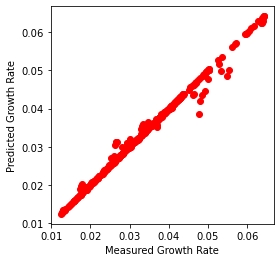

In [10]:
#plot the predicted results and calculate r2
figure =  plt.figure(figsize=(4,4))
plt.plot(df5['Measured Growth Rate'],df5['Predicted Growth Rate'],'ro')
plt.xlabel('Measured Growth Rate')
plt.ylabel('Predicted Growth Rate')
print(r2)  # expected output ~0.995 may be slight different 

# Section 3. Growth Simulation

#### Growth simulation for constant light. Simulation time is about 20 mins for all six conditions. code below use one condition as example

In [11]:
#do the simulation for constant light

#set the initial cell concentration and constant light intensity
#condition = [(0.0312,107),(0.0273,178),(0.0312,267),(0.0312,357),(0.0273,570),(0.0273,714)]   #takes about 20 min
condition = [(0.0312,107)]  #use this condition as example

df6 = pd.DataFrame()
df6['Time'] = np.array(list(range(160)))*0.5

for i in condition:
    print(i[0])
    initial_conc = [i[0]]
    light_program = np.ones(160)*i[1]
    pred_growth = run_simulation(initial_conc, light_program,0.5)
    df6[str(i[1])] = (dcw_denormalization(np.array(pred_growth)[:,0])/0.39)[:,0]

df6 = df6.set_index('Time')


#store the dataframe to csv
#df.to_csv('Simulated_growth_constant_light.csv')

df6.head()

0.0312
Simulation in progress ... 6.25  % Finished
Simulation in progress ... 12.5  % Finished
Simulation in progress ... 18.75  % Finished
Simulation in progress ... 25.0  % Finished
Simulation in progress ... 31.25  % Finished
Simulation in progress ... 37.5  % Finished
Simulation in progress ... 43.75  % Finished
Simulation in progress ... 50.0  % Finished
Simulation in progress ... 56.25  % Finished
Simulation in progress ... 62.5  % Finished
Simulation in progress ... 68.75  % Finished
Simulation in progress ... 75.0  % Finished
Simulation in progress ... 81.25  % Finished
Simulation in progress ... 87.5  % Finished
Simulation in progress ... 93.75  % Finished


,107
Time,
0.0,0.080000
0.5,0.094404
1.0,0.108993
1.5,0.123747
2.0,0.138804


#### Growth simulation for low light, high light and changing light. 

In [12]:
# low light 107, high light 714, changing light 178-714-178

#set initial cell concentrations 
initial_conc = np.array(list(range(15,175,5)))*0.01

#low light 
low_light = np.ones(49)*107

#high light 
high_light = np.ones(49)*714

#changing_light
changing_light = np.ones(17)*178   # ~8h of 178 
changing_light = np.append(changing_light,np.ones(16)*714)   # 8h of 714 
changing_light = np.append(changing_light,np.ones(16)*178)   # 8h of 178

#select light programs  = low_light or high_light or changing light
light_program = changing_light  

#run simulation
pred_growth = run_simulation(initial_conc, light_program,0.5)

#store the output into a dataframe
df7 = pd.DataFrame(dcw_denormalization(np.array(pred_growth)[:,:,0])/0.39)
df7.head()

Simulation in progress ... 20.408163265306122  % Finished
Simulation in progress ... 40.816326530612244  % Finished
Simulation in progress ... 61.224489795918366  % Finished
Simulation in progress ... 81.63265306122449  % Finished


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.384615,0.512821,0.641026,0.769231,0.897436,1.025641,1.153846,1.282051,1.410256,1.538462,...,3.205128,3.333333,3.461538,3.589744,3.717949,3.846154,3.974359,4.102564,4.230769,4.358974
1,0.408488,0.539371,0.670038,0.800473,0.930815,1.061475,1.191416,1.321563,1.451348,1.581054,...,3.254679,3.382250,3.509601,3.636787,3.764307,3.891614,4.018957,4.145841,4.272682,4.399313
2,0.432871,0.566386,0.699557,0.832168,0.964900,1.097726,1.229733,1.361503,1.493026,1.624140,...,3.303840,3.430895,3.557842,3.681417,3.810614,3.936866,4.063169,4.188648,4.314214,4.439104
3,0.457721,0.593888,0.729521,0.864679,0.999457,1.134520,1.268415,1.402019,1.535164,1.667712,...,3.352735,3.479477,3.605203,3.728153,3.856617,3.981826,4.106920,4.231063,4.355059,4.478365
4,0.483055,0.622023,0.760149,0.897734,1.034755,1.171700,1.307583,1.442941,1.577712,1.711637,...,3.400950,3.527818,3.651292,3.774440,3.902175,4.026482,4.150000,4.272938,4.395392,4.516968


# Section 4. GRM and Growth Simulation for Double Light 

In [ ]:
#read training data
df8 = pd.read_csv('growth_double_light_fitted_to_curve_w_LDP.csv')

#training and evaluation
y_test, yhat, y_pred,rs = GRM_training_prediction_dlight(df8,[])

#store evaluation results into a dataframe
df9 = pd.DataFrame()
df9['Measured GSVs'] = y_test
df9['Predicted GSNs'] = yhat

#store dataframe into a csv file
df9.to_csv('double_light_LDP_measured_vs_predicted.csv')


In [ ]:
figure =  plt.figure(figsize=(5,4))
plt.plot(np.array(y_test).reshape(-1),np.array(yhat).reshape(-1)*0.39,'ro')

In [ ]:
#set initial conditions
initial_conc = np.array(list(range(10,300,5)))*0.01
light_program = np.ones(48)*570

#run the simulation
record = run_simulation_dlight(initial_conc, light_program,0.5)

#store the simulation results into a dataframe
df10 = pd.DataFrame(dcw_denormalization(np.array(record)[:,:,0])/0.39)

#calculate the growth at different initial concentrations
growth = []
initial = [] 
for i in list(df10.columns):
    growth.append(df10[i][47]-df10[i][0])
    initial.append(df10[i][0])

df11 = pd.DataFrame()
df11['Initial OD'] = initial
df11['Biomass Productivity'] = np.array(growth)*0.39
 
df11.head()
df11.to_csv('Biomass_productivity_at_diff_initial_OD_dlight.csv')

In [ ]:
#plot the initla OD vs Biomass productivity
figure =  plt.figure(figsize=(5,4))
plt.plot(np.array(initial),np.array(growth)*0.39,'ro')
plt.xlabel('Initial OD')
plt.ylabel('Biomass productivity')